# Applied Data Science Capstone Project - The Battle of Neighborhood 

# Finding Best Neighbourhood to Start New Office in New York City 

#### Project by:- Nanduri V P S Anirudh 

## Importing required libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import json

## Downloading the data needed

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

### Subsetting file to extract data needed

In [4]:
neighborhoods_data = newyork_data['features']

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(neighborhoods['Borough'].unique()),neighborhoods.shape[0]))

The dataframe has 5 boroughs and 306 neighborhoods.


In [9]:
newyork_data = neighborhoods
newyork_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## Extracting geo information for New York City, NY to use it in map

In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [11]:
# create map of Manhattan using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(newyork_data['Latitude'], newyork_data['Longitude'], newyork_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Declaring Fouresquare API credentials

In [12]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: 1I0M5B0NXVLPVII3FTDISTSKGXQ4A2PQ0DBHDJWUNFPQGFUB
CLIENT_SECRET:100A5F4F1EZNFWNA1J31EOMIXPYYZSTJYCBEWP2WYRPK5VNY


## Extracting information required for a single neighborhood

In [13]:
newyork_data.loc[0, 'Neighborhood']

'Wakefield'

In [14]:
neighborhood_latitude = newyork_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = newyork_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = newyork_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


In [15]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # defining radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=1I0M5B0NXVLPVII3FTDISTSKGXQ4A2PQ0DBHDJWUNFPQGFUB&client_secret=100A5F4F1EZNFWNA1J31EOMIXPYYZSTJYCBEWP2WYRPK5VNY&v=20180605&ll=40.89470517661,-73.84720052054902&radius=500&limit=100'

In [16]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e97144b60ba08001b22dcb4'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Wakefield',
  'headerFullLocation': 'Wakefield, Bronx',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 9,
  'suggestedBounds': {'ne': {'lat': 40.899205181110005,
    'lng': -73.84125857127495},
   'sw': {'lat': 40.89020517211, 'lng': -73.8531424698231}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c537892fd2ea593cb077a28',
       'name': 'Lollipops Gelato',
       'location': {'address': '4120 Baychester Ave',
        'crossStreet': 'Edenwald & Bussing Ave',
        'lat': 40.894123150205274,
        'lng': -73.84589162362325,
        'labeledLatLn

In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Lollipops Gelato,Dessert Shop,40.894123,-73.845892
1,Rite Aid,Pharmacy,40.896649,-73.844846
2,Carvel Ice Cream,Ice Cream Shop,40.890487,-73.848568
3,Walgreens,Pharmacy,40.896528,-73.844700
4,Dunkin',Donut Shop,40.890459,-73.849089


In [19]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

9 venues were returned by Foursquare.


## Exploring all Neighborhoods

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            pass
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,lat,lng,v['venue']['name'],v['venue']['location']['lat'], 
            v['venue']['location']['lng'],v['venue']['categories'][0]['name']) for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood','Neighborhood Latitude', 
                  'Neighborhood Longitude','Venue','Venue Latitude', 
                  'Venue Longitude','Venue Category']
    
    return(nearby_venues)

In [21]:
newyork_venues = getNearbyVenues(names=newyork_data['Neighborhood'],
                                   latitudes=newyork_data['Latitude'],
                                   longitudes=newyork_data['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [22]:
newyork_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [23]:
print("The neighborhoods for which information was not retrieved are:",set(newyork_data['Neighborhood'])-set(newyork_venues['Neighborhood']))

The neighborhoods for which information was not retrieved are: {'Port Ivory', 'Howland Hook'}


## Bucketing the venue category information to extract better insights

In [24]:
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].str.contains('Restaurant'),'Hotel & Restaurant',newyork_venues['Venue Category'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].str.contains('shop'),'Store/Shop',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].str.contains('store'),'Store/Shop',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].str.contains('Shop'),'Store/Shop',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].str.contains('Store'),'Store/Shop',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].str.contains('Diner'),'Hotel & Restaurant',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].str.contains('Market'),'Other Services',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].str.contains('market'),'Other Services',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].str.contains('restaurant'),'Hotel & Restaurant',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].str.contains('Bar'),'Pubs, Bars, & Brewery',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].str.contains('Pub'),'Pubs, Bars, & Brewery',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].isin(['Zoo Exhibit','Roller Rink','Field','Circus','Resort','Club House','Rock Club','Jazz Club','Stadium','Performing Arts Venue','Social Club', 'Dance Studio', 'Tea Room', 'Pool Hall','Pool','Indie Theater','Harbor / Marina','Indie Movie Theater', 'Gaming Cafe','Pet Café', 'Rest Area','Comedy Club','Skating Rink', 'Surf Spot','Indoor Play Area','Recreation Center', 'Theme Park','Soccer Field','Baseball Stadium','Pilates Studio', 'Cycle Studio','Martial Arts Dojo','Rock Climbing Spot','Climbing Gym','Outdoors & Recreation', 'Racetrack','Track','Golf Course','Boxing Gym','Campground','Gym Pool', 'Volleyball Court','Bowling Alley','Mini Golf', 'Skate Park','Gymnastics Gym','Tennis Court','Sports Club','Design Studio','Tennis Stadium','Gym','Gym / Fitness Center','Basketball Court','Athletics & Sports','Playground','Baseball Field']),'Fun, Fitness, & Relaxation',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].isin(['Street Art', 'Exhibit','Bridge','Waterfront','Building','River','Music Venue','Sculpture Garden','Memorial Site','Tourist Places','Museum','Art Museum','History Museum', 'Art Gallery','Historic Site','Beach','Scenic Lookout','Monument / Landmark', 'Theme Park Ride / Attraction','Tourist Information Center',]),'Tourist Places',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].isin(['Bed & Breakfast','Poke Place','Cafeteria','Salad Place','Creperie','Buffet','Food','Snack Place','Steakhouse', 'Soup Place','Bakery', 'Breakfast Spot', 'Café','Food Court','Cha Chaan Teng','Taco Place','Noodle House','Food Stand','Dosa Place','Burrito Place','Wings Joint','Hot Dog Joint','BBQ Joint','Sandwich Place','Pizza Place','Food Truck','Burger Joint','Fried Chicken Joint']),'Food & Cafe',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].isin(['Boat or Ferry','Train Station','Bus Station','Bus Stop','Metro Station','Airport Terminal','Platform','Bus Line','Bike Trail','Train',]),'Transportation',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].isin(['Home Service','Lawyer','Spa','Business Service','Health & Beauty Service','Nail Salon','Financial or Legal Service','Pet Service','Entertainment Service','Rental Service','Event Service', 'Child Care Service','Bank','Rental Car Location','Bike Rental / Bike Share', 'Dry Cleaner','Laundry Service','Laundromat','Storage Facility','ATM','Tattoo Parlor','Locksmith','Heliport','Deli / Bodega','Gas Station','Waste Facility','Butcher','Organic Grocery','Church','Bath House','Adult Boutique',]),'Other Services',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].isin(['Check Cashing Service','IT Services', 'Weight Loss Center','Auto Garage','Outdoor Sculpture','Massage Studio','General Entertainment', 'Concert Hall', 'Dog Run', 'Opera House','Theater','Movie Theater','Roof Deck', 'Ski Area', 'Arts & Entertainment','Motel', 'Multiplex','Daycare','Auto Dealership', 'Outlet Mall','Recording Studio','Tanning Salon','Piercing Parlor','Photography Studio','Strip Club','Yoga Studio', 'Nightclub', 'Arcade','Boutique','Farm','Construction & Landscaping','Tree',]),'Other Services',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].isin(["Doctor's Office",'Eye Doctor','Physical Therapist','Medical Center','Veterinarian','Pharmacy',]),'Health Services',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].isin(['School', 'High School','College Arts Building','Music School','College Basketball Court','College Academic Building','College Cafeteria','Cooking School','Library',]),'Education Services',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].isin(['Factory','Coworking Space','Event Space','Insurance Office','Post Office','Tech Startup','Office',]),'Work Spaces',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].isin(['Garden Center','Park','Community Center','State / Provincial Park','Plaza','Trail','Other Great Outdoors','Intersection','Garden','Pedestrian Plaza',  'Lake',]),'Comminity Spaces and Parks',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].isin(['Brewery', 'Distillery','Beer Garden','Lounge','Gastropub','Other Nightlife','Speakeasy',]),'Pubs, Bars, & Brewery',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].isin(['Residential Building (Apartment / Condo)','Hostel']),'Living Spaces',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].isin(['Hotel','Bistro','Hotel Pool',]),'Hotel & Restaurant',newyork_venues['Venue Category Group'])
newyork_venues['Venue Category Group']=np.where(newyork_venues['Venue Category'].isin(['Neighborhood', 'Non-Profit', 'Moving Target','Fountain', 'Newsstand', 'Pier', 'Auditorium','Toll Plaza','Stables']),'Misc',newyork_venues['Venue Category Group'])
# newyork_venues=newyork_venues[~newyork_venues['Venue Category'].isin(['Neighborhood', 'Non-Profit', 'Moving Target','Fountain', 'Newsstand', 'Pier', 'Auditorium','Toll Plaza','Stables'])].reset_index(drop=True)


# newyork_venues

In [25]:
newyork_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category Group
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,Store/Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,Health Services
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,Store/Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy,Health Services
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop,Store/Shop


In [26]:
print("The number of unique values in Venue Category are:",len(set(newyork_venues['Venue Category'])))
print("The number of unique values in Venue Category Group are:",len(set(newyork_venues['Venue Category Group'])))

The number of unique values in Venue Category are: 421
The number of unique values in Venue Category Group are: 14


## Pre-processing data for analysing venue category group

In [27]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category Group']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.head()

,Neighborhood,Comminity Spaces and Parks,Education Services,Food & Cafe,"Fun, Fitness, & Relaxation",Health Services,Hotel & Restaurant,Living Spaces,Misc,Other Services,"Pubs, Bars, & Brewery",Store/Shop,Tourist Places,Transportation,Work Spaces
0,Wakefield,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,Wakefield,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,Wakefield,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [28]:
newyork_grouped = newyork_onehot.groupby('Neighborhood').sum().reset_index()
newyork_grouped.head()

,Neighborhood,Comminity Spaces and Parks,Education Services,Food & Cafe,"Fun, Fitness, & Relaxation",Health Services,Hotel & Restaurant,Living Spaces,Misc,Other Services,"Pubs, Bars, & Brewery",Store/Shop,Tourist Places,Transportation,Work Spaces
0,Allerton,1,0,7,1,1,4,0,0,9,0,6,0,3,0
1,Annadale,0,0,3,1,1,2,0,0,1,2,0,0,1,0
2,Arden Heights,0,0,1,0,1,0,0,0,1,0,1,0,1,0
3,Arlington,0,0,0,0,0,0,0,0,1,0,1,0,3,0
4,Arrochar,0,0,4,2,0,6,0,0,3,0,3,0,2,0


In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,Allerton,Other Services,Food & Cafe,Store/Shop,Hotel & Restaurant
1,Annadale,Food & Cafe,"Pubs, Bars, & Brewery",Hotel & Restaurant,Transportation
2,Arden Heights,Transportation,Store/Shop,Other Services,Health Services
3,Arlington,Transportation,Store/Shop,Other Services,Work Spaces
4,Arrochar,Hotel & Restaurant,Food & Cafe,Store/Shop,Other Services


In [31]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted.columns[1:]].mode()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,Hotel & Restaurant,Store/Shop,Food & Cafe,Other Services


In [32]:
newyork_grouped.head()

,Neighborhood,Comminity Spaces and Parks,Education Services,Food & Cafe,"Fun, Fitness, & Relaxation",Health Services,Hotel & Restaurant,Living Spaces,Misc,Other Services,"Pubs, Bars, & Brewery",Store/Shop,Tourist Places,Transportation,Work Spaces
0,Allerton,1,0,7,1,1,4,0,0,9,0,6,0,3,0
1,Annadale,0,0,3,1,1,2,0,0,1,2,0,0,1,0
2,Arden Heights,0,0,1,0,1,0,0,0,1,0,1,0,1,0
3,Arlington,0,0,0,0,0,0,0,0,1,0,1,0,3,0
4,Arrochar,0,0,4,2,0,6,0,0,3,0,3,0,2,0


## Clustering

In [33]:
X=newyork_grouped[newyork_grouped.columns[1:]].values

In [34]:
# The code was removed by Watson Studio for sharing.

In [35]:
X

array([[ 1,  0,  7, ...,  0,  3,  0],
       [ 0,  0,  3, ...,  0,  1,  0],
       [ 0,  0,  1, ...,  0,  1,  0],
       ...,
       [ 0,  0,  2, ...,  0,  0,  0],
       [ 0,  0, 13, ...,  0,  2,  0],
       [ 2,  0, 10, ...,  1,  0,  0]], dtype=uint8)

In [36]:
cluster_range = range(1, 10)
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters,random_state=100)
    clusters.fit(X)
    cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df['Percentage_change']=round((clusters_df['cluster_errors'].shift()-clusters_df['cluster_errors'])/clusters_df['cluster_errors']*100,3)
clusters_df

,num_clusters,cluster_errors,Percentage_change
0,1,72157.626667,NaN
1,2,27632.214963,161.136
2,3,20396.973788,35.472
3,4,17498.914238,16.561
4,5,15383.186926,13.754
5,6,14321.242998,7.415
6,7,12916.130688,10.879
7,8,12362.993060,4.474
8,9,11427.006782,8.191


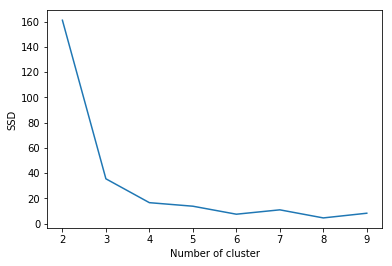

In [37]:
plt.figure()
plt.plot(clusters_df['num_clusters'][0:10], clusters_df['Percentage_change'][0:10])
plt.xlabel("Number of cluster")
plt.ylabel("SSD")
plt.show()

In [38]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=100).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 3, 2, 2, 0], dtype=int32)

In [39]:
print(newyork_grouped.shape)
print(neighborhoods_venues_sorted.shape)

(300, 15)
(300, 5)


In [40]:
len(kmeans.labels_)

300

In [41]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,Allerton,Other Services,Food & Cafe,Store/Shop,Hotel & Restaurant
1,Annadale,Food & Cafe,"Pubs, Bars, & Brewery",Hotel & Restaurant,Transportation
2,Arden Heights,Transportation,Store/Shop,Other Services,Health Services
3,Arlington,Transportation,Store/Shop,Other Services,Work Spaces
4,Arrochar,Hotel & Restaurant,Food & Cafe,Store/Shop,Other Services


In [42]:
# add clustering labels
neighborhoods_venues_sorted['Cluster Labels']=kmeans.labels_

newyork_merged = newyork_data
newyork_merged = newyork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
newyork_merged.head()

,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,Cluster Labels
0,Bronx,Wakefield,40.894705,-73.847201,Store/Shop,Health Services,Food & Cafe,Other Services,2.0
1,Bronx,Co-op City,40.874294,-73.829939,Store/Shop,Hotel & Restaurant,Transportation,"Fun, Fitness, & Relaxation",2.0
2,Bronx,Eastchester,40.887556,-73.827806,Hotel & Restaurant,Transportation,Store/Shop,Other Services,2.0
3,Bronx,Fieldston,40.895437,-73.905643,Transportation,Comminity Spaces and Parks,Work Spaces,Tourist Places,2.0
4,Bronx,Riverdale,40.890834,-73.912585,"Fun, Fitness, & Relaxation",Comminity Spaces and Parks,Other Services,Transportation,2.0


In [43]:
newyork_merged=newyork_merged[~newyork_merged['Cluster Labels'].isnull()].reset_index(drop=True)
newyork_merged['Cluster Labels']=newyork_merged['Cluster Labels'].astype('int')

In [44]:
newyork_grouped['Cluster Labels']=kmeans.labels_

In [45]:
newyork_grouped.groupby('Cluster Labels').mean()

,Comminity Spaces and Parks,Education Services,Food & Cafe,"Fun, Fitness, & Relaxation",Health Services,Hotel & Restaurant,Living Spaces,Misc,Other Services,"Pubs, Bars, & Brewery",Store/Shop,Tourist Places,Transportation,Work Spaces
Cluster Labels,,,,,,,,,,,,,,
0,1.225352,0.112676,7.014085,2.394366,0.971831,12.380282,0.084507,0.084507,4.718310,2.647887,10.098592,1.028169,0.774648,0.140845
1,2.043478,0.217391,13.913043,7.347826,0.782609,22.739130,0.086957,0.086957,8.782609,7.782609,26.173913,1.695652,0.304348,0.304348
2,0.568306,0.032787,2.256831,1.054645,0.409836,2.748634,0.016393,0.076503,2.049180,0.595628,3.142077,0.371585,0.928962,0.016393
3,1.826087,0.130435,12.000000,5.869565,0.608696,36.000000,0.086957,0.130435,7.652174,11.826087,18.608696,1.434783,0.043478,0.043478


The insights for each cluster:

__Cluster 0 :__
The neighborhoods in this cluster have good health serices, transportation, and work spaces near them. Could be considered as a decent place to live in for people who do not care that much about fun and relaxation

__Cluster 1 :__
The neighborhoods in this cluster have most services being offered as well as most educational places when compared to other clusters while having a good number of work spaces, hotels, and parks. This would definetely be a good candidate for the customers who can spend a little for their accomodation as the neighborhoods in this cluster are tend to be a bit expensive considering that all factors are available here. This place is also good for people who want to expand business as this place clearly has a good footfall.

__Cluster 2 :__
The neighborhoods in this cluster seem to be behind all other neighborhoods except for the fact that it has a good transportation facility. It is probably a place which can be developed later and might be a good place for future investment.

__Cluster 3 :__
The neighborhoods in this cluster have the most hotels, shops, and pubs. This place is probably more ideal for setting up shops rather than living.

## Visualizing clusters

In [46]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'], newyork_merged['Longitude'], newyork_merged['Neighborhood'], newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters